Diffusion maps and RMSD calculations using JAX 

SD | FergLab

ADP example

In [1]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import time
import pickle
import sys

sys.path.append('../')
from dmap_JAX import rmsd_jax as rjax
from dmap_JAX import dMap_jax as djax
from dmap_JAX import diff_plots as dplots


from MDAnalysis.analysis import rms

import jax.numpy as jnp
import numpy as np

plot settings

In [2]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

load trajectories

In [3]:
# example trajectory (mdshare: https://markovmodel.github.io/mdshare/ALA2/#alanine-dipeptide)
filepath = '/work2/03273/tg825722/shared-folder-siva/doe/analysis-integrin/archive-integrin/integrin-data/adp-data/data/'
universe_adp = []
for rep in range(3):
    universe_adp.append(mda.Universe(filepath + 'alanine-dipeptide-nowater.pdb', 
                                     filepath + 'alanine-dipeptide-'+str(rep)+'-250ns-nowater.xtc'))


/home1/03273/tg825722/.local/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


convert to array 

In [4]:
lag_n = 50 # in ps # skip frames and even atoms, if needed (to reduce memory requirements)
# for example skipping 50 frames in each replica.
test_trajs = jnp.concatenate([x.trajectory.timeseries()[::lag_n] for x in universe_adp])
print(test_trajs.shape)

(15000, 22, 3)


rmsd calculations using JAX

run and plot RMSD (similarity metric)

In [5]:
# calculate pairwise RMSD
start = time.time()

# Adjust batch size depending on available memory. batch size implies the number of
# reference frames used for computing RMSD-RMSD in each batch.
rjax.run_rmsd(jnp.array(test_trajs), 
              batch_ref_frame_size=100, 
              nref_frames=test_trajs.shape[0] + 1, 
              output_file_prefix="test_outputdata/pair_rmsd_")

print("RMSD calculations finished in {} seconds".format(time.time()-start))


running pairwise rmsd between same traj. Batch: 0
running pairwise rmsd between same traj. Batch: 100
running pairwise rmsd between same traj. Batch: 200
running pairwise rmsd between same traj. Batch: 300
running pairwise rmsd between same traj. Batch: 400
running pairwise rmsd between same traj. Batch: 500
running pairwise rmsd between same traj. Batch: 600
running pairwise rmsd between same traj. Batch: 700
running pairwise rmsd between same traj. Batch: 800
running pairwise rmsd between same traj. Batch: 900
running pairwise rmsd between same traj. Batch: 1000
running pairwise rmsd between same traj. Batch: 1100
running pairwise rmsd between same traj. Batch: 1200
running pairwise rmsd between same traj. Batch: 1300
running pairwise rmsd between same traj. Batch: 1400
running pairwise rmsd between same traj. Batch: 1500
running pairwise rmsd between same traj. Batch: 1600
running pairwise rmsd between same traj. Batch: 1700
running pairwise rmsd between same traj. Batch: 1800
runni

In [6]:
# load saved RMSD into memory
sym_prmsd_jax = rjax.load_rmsd(nref_frames=test_trajs.shape[0] + 1, 
                               batch_ref_frame_size=100, 
                               input_file_prefix="test_outputdata/pair_rmsd_", 
                               tol=1e-5)


Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 


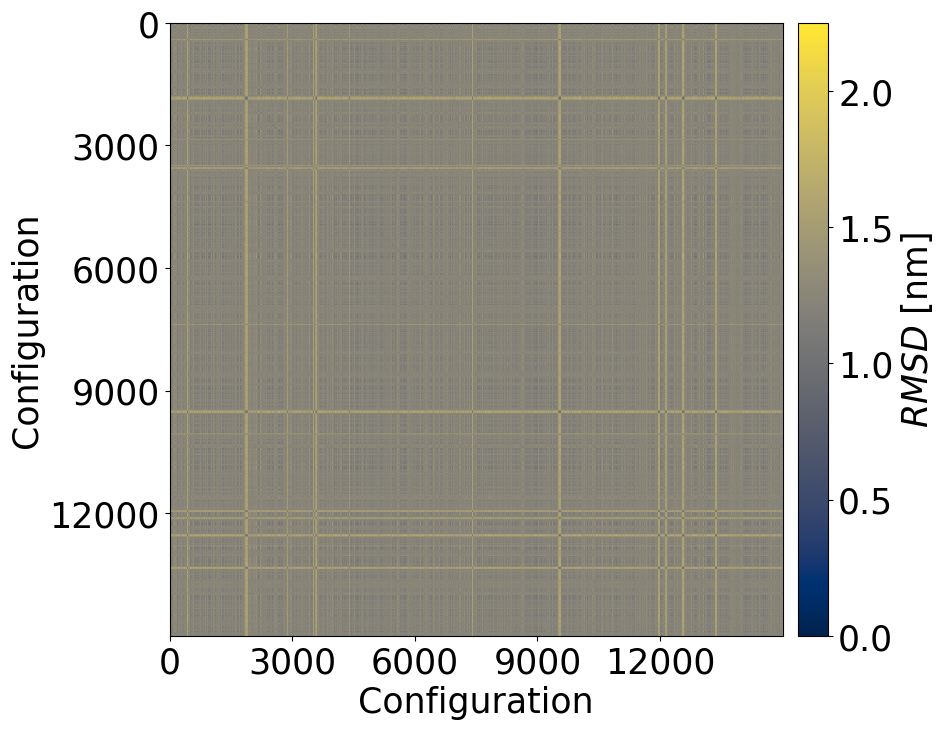

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1,1, figsize = (10,10))

im1 = axes.imshow(sym_prmsd_jax, cmap='cividis', vmin=0)

axes.set_xlabel('Configuration')
axes.set_ylabel('Configuration')

axes.set_xticks(ticks=list(np.arange(0,15000, 3000)), labels=list(np.arange(0,15000, 3000)))
axes.set_yticks(ticks=list(np.arange(0,15000, 3000)), labels=list(np.arange(0,15000, 3000)))

divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im1, cax=cax, orientation='vertical', label='$RMSD$ [nm]')


fig.tight_layout()    
#fig.savefig('jax-rmsd-integrin-full.png',dpi=150)

Plot sum_A (A is similarity matrix or RMSD matrix) vs epsilon in log scale (fractal dimension)

See SI of [Ferguson et al., PNAS 2010: https://www.pnas.org/doi/abs/10.1073/pnas.1003293107](https://www.pnas.org/doi/abs/10.1073/pnas.1003293107)

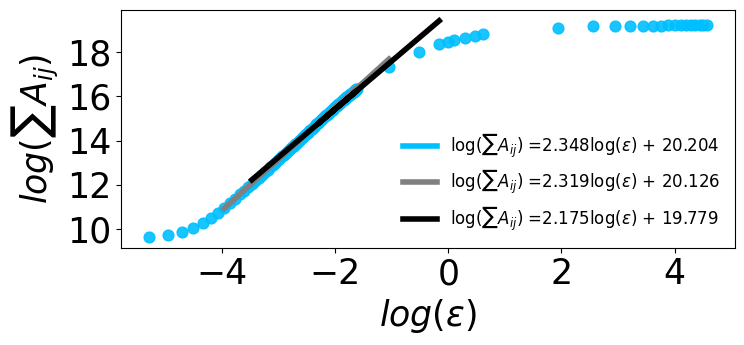

In [8]:
#### generate a range of epsilon

epsilon = jnp.concatenate(( jnp.arange(0.005,0.2,.002), jnp.arange(0.1,2,.25), jnp.arange(1,100,6) ))

#print(epsilon)

sum_A = []
for e in epsilon:
    A = jnp.exp(-jnp.square(sym_prmsd_jax)/(2*e))
    
    sum_A.append(A.sum())
    
    
    
fig, axes = plt.subplots(1, 1, figsize = (8,4))

plt.scatter(np.log(epsilon), np.log(sum_A), alpha=0.9, color='deepskyblue',s=60)

#plt.yscale('log')
#plt.xscale('log')

#plt.ylim(0,1e5)
plt.xlabel(r'$log(\epsilon)$') #[nm$^{2}$]
plt.ylabel(r'$log(\sum A_{ij})$')


def linear_fit(x, a, b):
    return a*x + b

from scipy.optimize import curve_fit

### case 1
e2_1 = np.log(epsilon)[np.log(epsilon)>-4]
a2_1 = np.log(sum_A)[np.log(epsilon)>-4]
a2_1 = a2_1[e2_1<-2]
e2_1 = e2_1[e2_1<-2]

### case 2
e2_2 = np.log(epsilon)[np.log(epsilon)>-4]
a2_2 = np.log(sum_A)[np.log(epsilon)>-4]
a2_2 = a2_2[e2_2<-1]
e2_2 = e2_2[e2_2<-1]

### case 3
e2_3 = np.log(epsilon)[np.log(epsilon)>-3.5]
a2_3 = np.log(sum_A)[np.log(epsilon)>-3.5]
a2_3 = a2_3[e2_3<0]
e2_3 = e2_3[e2_3<0]

popt_1, _ = curve_fit(linear_fit, e2_1, a2_1, p0=(1,0))
popt_2, _ = curve_fit(linear_fit, e2_2, a2_2, p0=(1,0))
popt_3, _ = curve_fit(linear_fit, e2_3, a2_3, p0=(1,0))


plt.plot(e2_1, linear_fit(e2_1, popt_1[0], popt_1[1]), color="deepskyblue", lw=4, label='log($\sum A_{ij}$) ='+str(round(popt_1[0],3))+'log($\epsilon$) + '+str(round(popt_1[1],3)))
plt.plot(e2_2, linear_fit(e2_2, popt_2[0], popt_2[1]), color="gray", lw=4, label='log($\sum A_{ij}$) ='+str(round(popt_2[0],3))+'log($\epsilon$) + '+str(round(popt_2[1],3)))
plt.plot(e2_3, linear_fit(e2_3, popt_3[0], popt_3[1]), color="black", lw=4, label='log($\sum A_{ij}$) ='+str(round(popt_3[0],3))+'log($\epsilon$) + '+str(round(popt_3[1],3)))

#scipy.optimize.curve_fit(func, x, y)

plt.legend(fontsize=12,frameon=False)
plt.locator_params(axis='both', nbins=10)

#plt.title(r'ref frame: {0}'.format(ref_i), fontsize=32)

fig.tight_layout()
#fig.savefig('epsilon-integrin-A.png',dpi=150)


Choose epislon (twice the slope or the plateau region in A-epsilon plot in log scale). Alternatively choose epsilon using grid search.

In [9]:
log_selected_e = 4
print(log_selected_e)
selected_e = np.exp(log_selected_e)
print(selected_e)

alpha=None # for adaptive diffusion maps
print(alpha) 

4
54.598150033144236
None


Run diffusion maps with JAX

In [11]:
# Also use MDAnalysis variant: https://docs.mdanalysis.org/1.0.0/documentation_pages/analysis/diffusionmap.html
# for comparison of performance

start = time.time()
print(f"eps is set to {selected_e} and alpha is set to {alpha}".format(selected_e))
lamb, psi = djax.diffMaps(selected_e, sym_prmsd_jax, alpha=alpha,
                          jit_compile=True, check_pos_definite=True, tol=-1e-4)
print("JAX dMap calculations finished in {} seconds".format(time.time()-start)) 


eps is set to 54.598150033144236 and alpha is set to None
Applying normal diffusion map as alpha is :None
JAX dMap calculations finished in 12.931822061538696 seconds


In [12]:
### save results
#### save dMap
with open(r"test_outputdata/evecs_evals_adp_e_"+str(selected_e)+".pkl", 'wb') as f:
    pickle.dump({'lamb': np.array(lamb),
                 'psi': np.array(psi)}
                ,f)

In [13]:
### load dMAP
with open(r"test_outputdata/evecs_evals_adp_e_"+str(selected_e)+".pkl", "rb") as input_file:
    dMaps_saved = pickle.load(input_file)

lamb = dMaps_saved['lamb']
psi = dMaps_saved['psi']

Plot eigenvalue spectrum

Sanity check: eigenvalues should be positive. if it is negative. matrix is not probably not symmetric (check matrix) or semidefinite (try other epsilon).

In [15]:
#%matplotlib inline
#dplots.plotspect(lamb[-20:], log_selected_e, alpha, skip_lead=True, figSuffix='_opt1')
#diff_plots.plotspect(lamb[-20:], selected_e, skip_lead=True, figSuffix='trail_opt1')

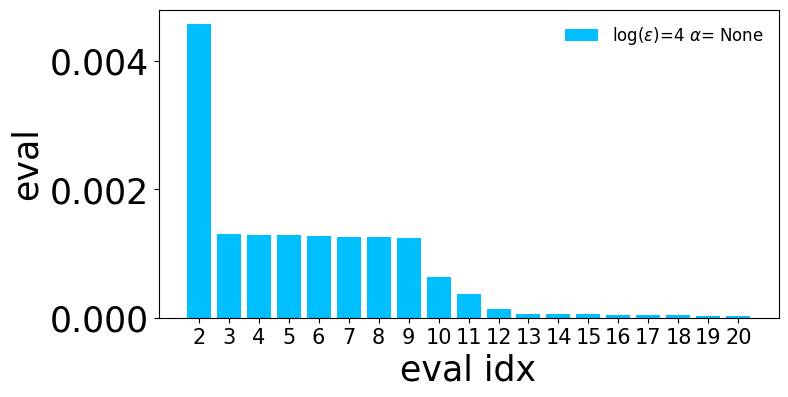

In [16]:
%matplotlib inline
dplots.plotspect(lamb[:20], log_selected_e, alpha, skip_lead=True, figSuffix='_opt1')
#diff_plots.plotspect(lamb[-20:], selected_e, skip_lead=True, figSuffix='trail_opt1')

Plot dMaps

nplots_split:3
7


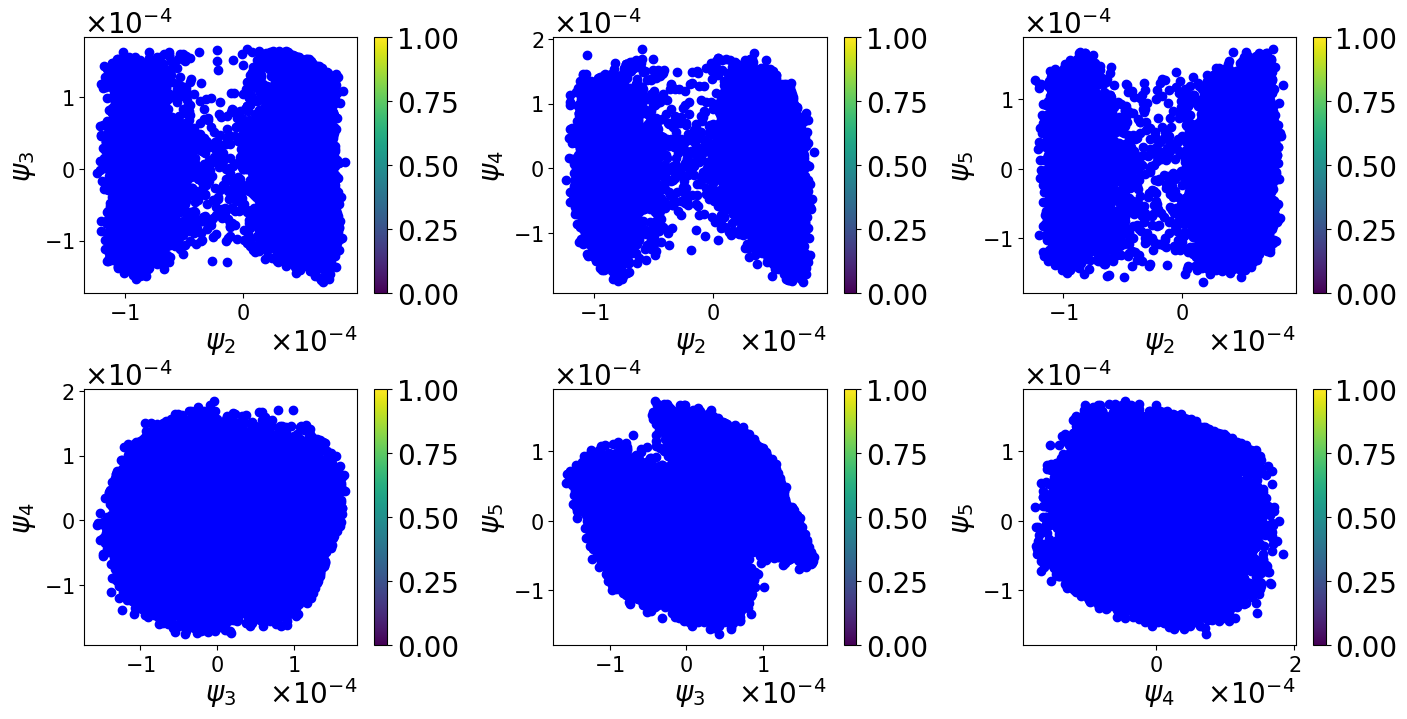

In [19]:
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

#colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3,
#          np.ones(2450)*4]

#lcmap = (mpl.colors.ListedColormap(['gray', 'orange', 'green', 'black'])
#        .with_extremes(over='0.25', under='0.75'))

colors = 'blue'

dplots.plot2Dmaps(psi, selected_e, plot_stride=1, select_max_vecs=4, 
                  skip_lead=True, colorMap=colors, cmap='cividis', ticks=None,
                  colorbar=True, colorlabel='', figSuffix='2d_opt1', 
                  cticklabels=None, singlecolorbar=True)

compute phi and psi

In [50]:
# !wget http://ftp.imp.fu-berlin.de/pub/cmb-data/alanine-dipeptide-x250ns-backbone-dihedrals.npz
with np.load('test_outputdata/alanine-dipeptide-3x250ns-backbone-dihedrals.npz') as data:
    dihedrals = [data[f"arr_{i}"] for i in range(3)]
    
dihedrals = jnp.concatenate(dihedrals)[::lag_n]

color dMap with phi and psi

nplots_split:3
7


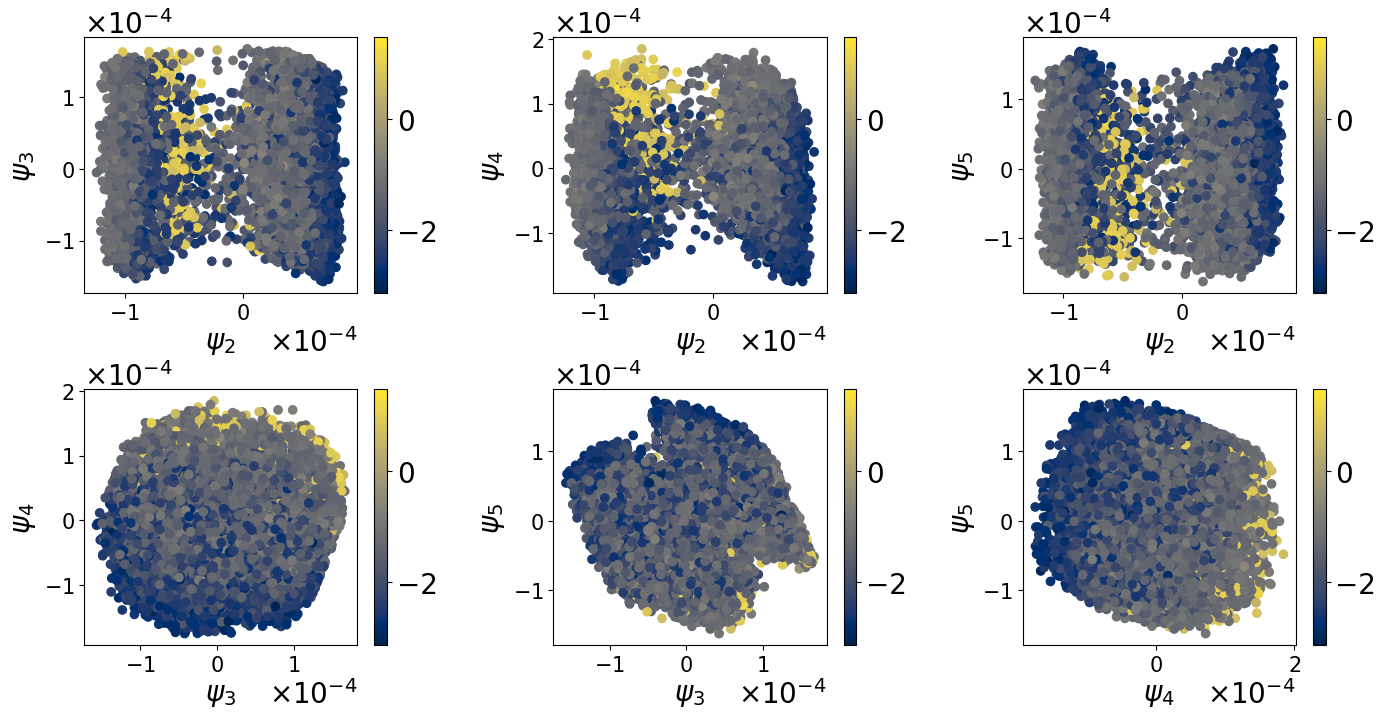

In [55]:
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

#colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3,
#          np.ones(2450)*4]

#lcmap = (mpl.colors.ListedColormap(['gray', 'orange', 'green', 'black'])
#        .with_extremes(over='0.25', under='0.75'))

colors = dihedrals[:,0]

dplots.plot2Dmaps(psi, selected_e, plot_stride=1, select_max_vecs=4, 
                  skip_lead=True, colorMap=colors, cmap='cividis', ticks=None,
                  colorbar=True, colorlabel='', figSuffix='2d_opt1', 
                  cticklabels=None, singlecolorbar=True)

nplots_split:3
7


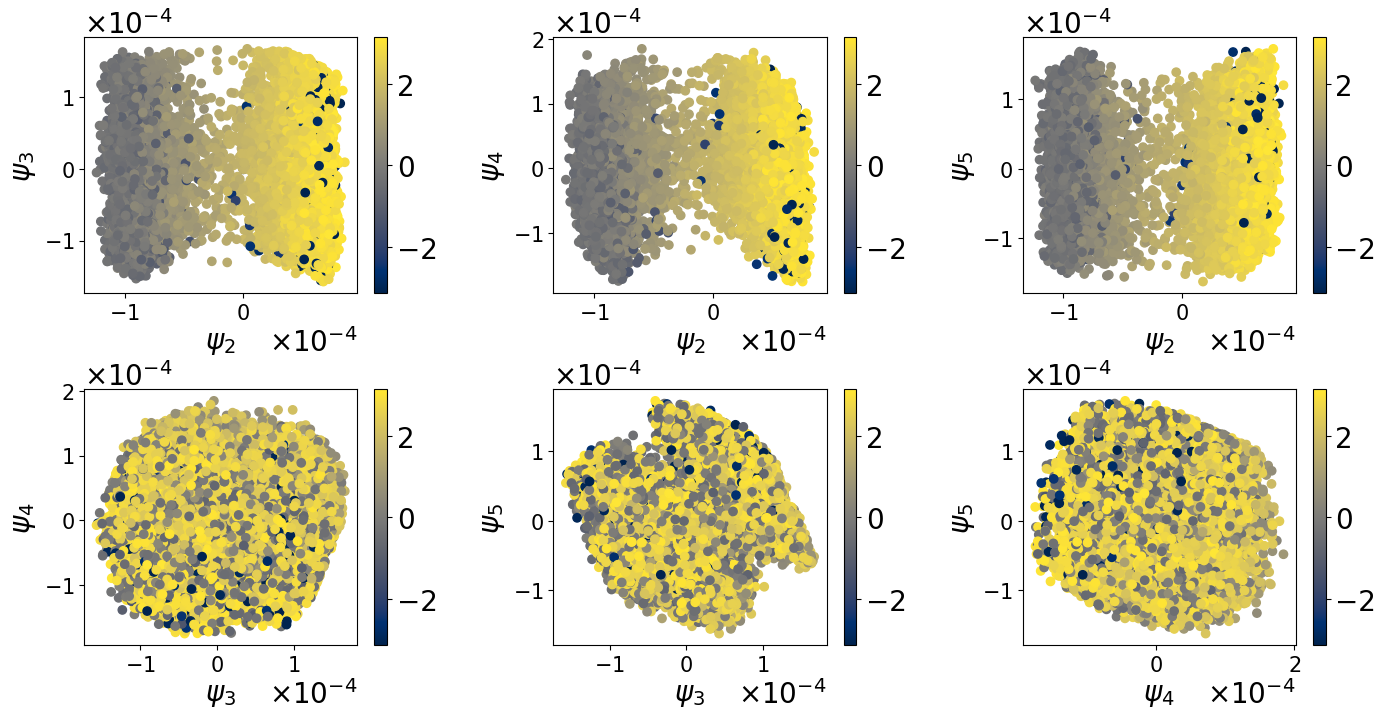

In [56]:
font = {'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

#colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3,
#          np.ones(2450)*4]

#lcmap = (mpl.colors.ListedColormap(['gray', 'orange', 'green', 'black'])
#        .with_extremes(over='0.25', under='0.75'))

colors = dihedrals[:,1]

dplots.plot2Dmaps(psi, selected_e, plot_stride=1, select_max_vecs=4, 
                  skip_lead=True, colorMap=colors, cmap='cividis', ticks=None,
                  colorbar=True, colorlabel='', figSuffix='2d_opt1', 
                  cticklabels=None, singlecolorbar=True)